In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
DATA_ROOT = 'data'
DATA_TRAIN = os.path.join(DATA_ROOT, 'train.json')
DATA_TEST = os.path.join(DATA_ROOT, 'test.json')
SUBMISSION = os.path.join(DATA_ROOT, 'submission.csv')

# Get to know the data

In [3]:
train_data = pd.read_json(DATA_TRAIN).set_index('id')
test_data = pd.read_json(DATA_TEST).set_index('id')
train_len = len(train_data)
all_data = pd.concat([train_data, test_data], sort=False)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49718 entries, 10259 to 1443
Data columns (total 2 columns):
cuisine        39774 non-null object
ingredients    49718 non-null object
dtypes: object(2)
memory usage: 1.1+ MB


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 10259 to 2362
Data columns (total 2 columns):
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: object(2)
memory usage: 932.2+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9944 entries, 18009 to 1443
Data columns (total 1 columns):
ingredients    9944 non-null object
dtypes: object(1)
memory usage: 155.4+ KB


No missing data, which makes sense since there is only one data column (**ingredients**) so missing = impossible to make prediction. 

In [6]:
all_data.head()

,cuisine,ingredients
id,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
22213,indian,"[water, vegetable oil, wheat, salt]"
13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


# Feature engineer & Visualization

### Cuisine type

First, let's take a look at what we have to predict

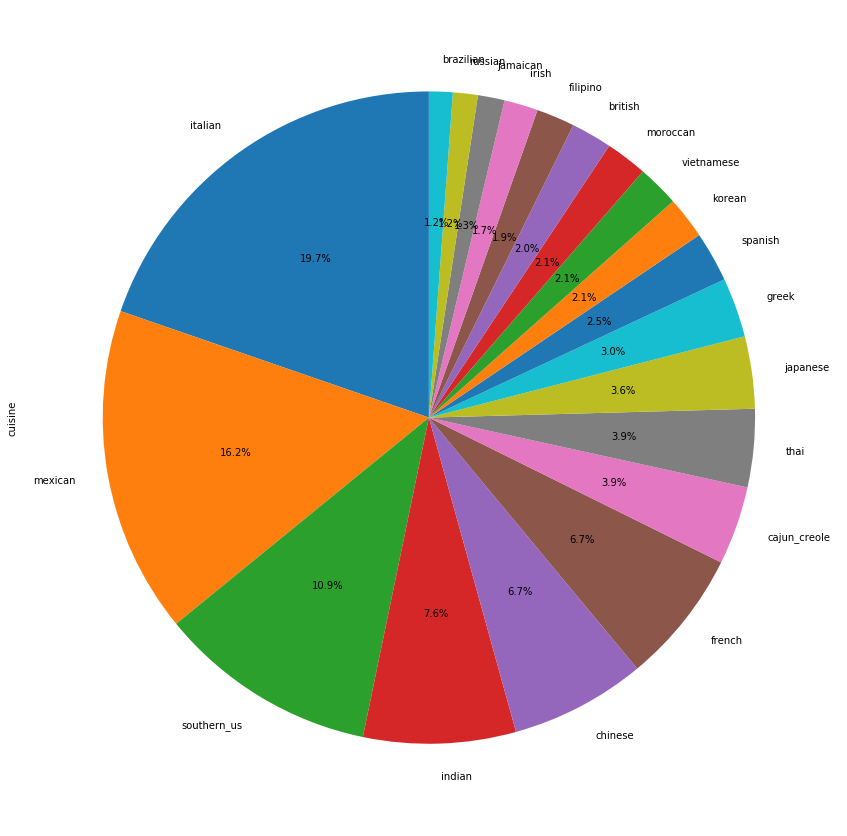

In [7]:
plt.figure(figsize=(15,15))
train_data.cuisine.value_counts().plot.pie(autopct='%1.1f%%', startangle=90)

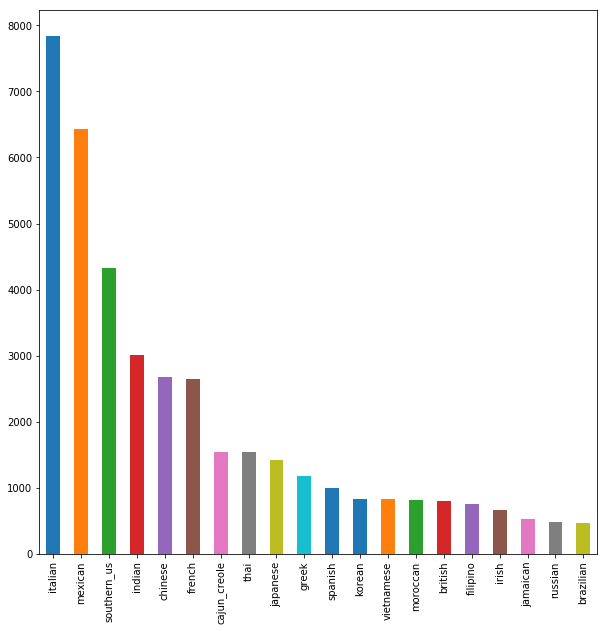

In [8]:
plt.figure(figsize=(10,10))
train_data.cuisine.value_counts().plot.bar()

Italian and Mexican dishes take up a large portion of our data, which is not very good.
@todo: We leave it for now, but you may want to apply some techniques to deal with the unbalanceness later.

BTW, we should change the **cuisine** column to categorical type

In [9]:
all_data.cuisine = all_data.cuisine.astype('category')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49718 entries, 10259 to 1443
Data columns (total 2 columns):
cuisine        39774 non-null category
ingredients    49718 non-null object
dtypes: category(1), object(1)
memory usage: 826.2+ KB


### Ingredients

I'm interested in the number of ingredients. Let's see if it can help us determining the cuisine type

In [10]:
all_data['nrof_ingredients'] = all_data.ingredients.apply(len)
all_data.nrof_ingredients.describe()

count    49718.000000
mean        10.774166
std          4.436613
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: nrof_ingredients, dtype: float64

Wow, I want to try that dish with 65 ingredients! But spare me from making it.

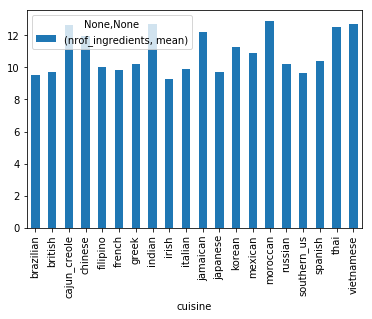

In [11]:
train_data['nrof_ingredients'] = train_data.ingredients.apply(len)
train_data.groupby('cuisine').agg(['mean']).plot.bar()

**cajun_creole**, **indian**, **jamaican**, **moroccan**, **thai** and **vietnamese** use more ingredients (on average) than the rest

Let's see how many unique ingredients there are and how often they are used.

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
ingredients = pd.DataFrame(mlb.fit_transform(all_data.ingredients), columns=mlb.classes_, index=all_data.index)
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49718 entries, 10259 to 1443
Columns: 7137 entries, (    oz.) tomato sauce to zucchini blossoms
dtypes: int64(7137)
memory usage: 2.6 GB


7137 unique ingredients and the data frame takes up 2.6 GB of memory!
Too many zeroes in there. Better use something less memory-consuming for now.

In [13]:
from collections import Counter

ingredient_counter = Counter()
# This will take a while
for idx, row in all_data.iterrows():
    ingredient_counter += Counter(row.ingredients)

In [14]:
len(ingredient_counter)

7137

In [15]:
ingredient_counter.most_common(50)

[('salt', 22534),
 ('onions', 10008),
 ('olive oil', 9889),
 ('water', 9293),
 ('garlic', 9171),
 ('sugar', 8064),
 ('garlic cloves', 7772),
 ('butter', 6078),
 ('ground black pepper', 5990),
 ('all-purpose flour', 5816),
 ('vegetable oil', 5516),
 ('pepper', 5508),
 ('eggs', 4262),
 ('soy sauce', 4120),
 ('kosher salt', 3930),
 ('green onions', 3817),
 ('tomatoes', 3812),
 ('large eggs', 3700),
 ('carrots', 3542),
 ('unsalted butter', 3474),
 ('ground cumin', 3431),
 ('extra-virgin olive oil', 3424),
 ('black pepper', 3291),
 ('milk', 2851),
 ('chili powder', 2519),
 ('oil', 2426),
 ('red bell pepper', 2423),
 ('purple onion', 2372),
 ('scallions', 2372),
 ('grated parmesan cheese', 2367),
 ('corn starch', 2230),
 ('ginger', 2190),
 ('sesame oil', 2183),
 ('jalapeno chilies', 2170),
 ('baking powder', 2168),
 ('dried oregano', 2163),
 ('chopped cilantro fresh', 2128),
 ('fresh lemon juice', 2105),
 ('diced tomatoes', 2065),
 ('minced garlic', 2001),
 ('fresh parsley', 1988),
 ('sour c

@todo: You might want to visualize these numbers, as well as the usage of ingredients for different types of cuisine.
For example, try to see what are the top ingredients for Italian cuisine, and compare it to the Japanese's top.

@todo: You also might want to see if there is any ingredient that's used exclusively for one type of cuisine.
For example, **japanese noodles** is only used in **japanese** cuisine (of course!)

There seems to be some noise; for example **ground black pepper** and **pepper** might be considered the same thing. Same goes for **eggs** and **large eggs**.

@todo: For the purpose of this starter notebook, I leave the noises as-is. You can venture into the world of NLP and try to clean them up a little bit.

# Modeling

In [16]:
all_data = all_data.join(ingredients).drop('ingredients', axis=1)

In [17]:
train_data = all_data[:train_len]
test_data = all_data[train_len:].drop('cuisine', axis=1)

In [20]:
y_train = train_data.cuisine.copy()
x_train = train_data.drop('cuisine', axis=1)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [26]:
model = LogisticRegression(multi_class='ovr', solver='liblinear')  # Simple one-over-rest logistic regression
score = cross_validate(model, x_train, y_train, cv=5, return_train_score=False)
score["test_score"].mean()

0.7813404219580422

# Submission

In [28]:
model.fit(x_train, y_train)
submission = model.predict(test_data)
submission_df = pd.Series(submission, index=test_data.index).rename('cuisine')
submission_df.to_csv(SUBMISSION, index=True, header=True)
print(submission_df.head())

id
18009         british
28583     southern_us
41580         italian
29752    cajun_creole
35687         italian
Name: cuisine, dtype: object
